In [2]:
import mne
import os
import re

# load data, I'm using NDARAA396TWZ and NDARAA773LUW as samples
resting_state_path = "sub-NDARAA396TWZ_task-RestingState_eeg.set"
contrast_change_path = "sub-NDARAA773LUW_task-contrastChangeDetection_run-1_eeg.set"

raw_data = []
raw_dir = os.path.join('..', '..', 'raw')
for file_name in [resting_state_path, contrast_change_path]:
    file_path = os.path.join(raw_dir, file_name)
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw_data.append(raw)

resting_state, contrast_change = raw_data
resting_state_sfreq = resting_state.info['sfreq']
contrast_change_sfreq = contrast_change.info['sfreq']

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [4]:
class EEGDataset(Dataset):
    def __init__(self, eeg_data, labels):
        """
        eeg_data: numpy array of shape (num_samples, C, T)
        labels: numpy array of shape (num_samples, E)
        """
        self.x_prev = eeg_data[:-1]       # previous segment
        self.x_next = eeg_data[1:]        # next segment
        self.labels = labels[1:]          # label for next segment

    def __len__(self):
        return len(self.x_prev)

    def __getitem__(self, idx):
        return (torch.tensor(self.x_prev[idx], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.float32),
                torch.tensor(self.x_next[idx], dtype=torch.float32))

In [5]:
class Discriminator(nn.Module):
    def __init__(self, C, T, E, hidden_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(C*T + E, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x, label):
        x = torch.cat([x.flatten(start_dim=1), label], dim=1)
        return self.model(x)

In [6]:
class Generator(nn.Module):
    def __init__(self, C, T, E, hidden_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(C*T + E, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, C*T),
            nn.Tanh()  # EEG normalized between -1 and 1
        )
        self.C = C
        self.T = T

    def forward(self, x_prev, label):
        x = torch.cat([x_prev.flatten(start_dim=1), label], dim=1)
        out = self.model(x)
        return out.view(-1, self.C, self.T)

In [7]:
def train_gan(dataloader, G, D, G_optimizer, D_optimizer, epochs=100, device='cpu'):
    criterion = nn.BCELoss()
    mse = nn.MSELoss()

    for epoch in range(epochs):
        for x_prev, label, x_next in dataloader:
            x_prev, label, x_next = x_prev.to(device), label.to(device), x_next.to(device)

            batch_size = x_prev.size(0)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # --- Train Discriminator ---
            D_optimizer.zero_grad()
            # Real
            D_real = D(x_next, label)
            loss_real = criterion(D_real, real_labels)
            # Fake
            x_fake = G(x_prev, label).detach()  # detach so gradients don't flow to G
            D_fake = D(x_fake, label)
            loss_fake = criterion(D_fake, fake_labels)

            D_loss = (loss_real + loss_fake) / 2
            D_loss.backward()
            D_optimizer.step()

            # --- Train Generator ---
            G_optimizer.zero_grad()
            x_fake = G(x_prev, label)
            D_fake = D(x_fake, label)
            adv_loss = criterion(D_fake, real_labels)       # try to fool D
            pred_loss = mse(x_fake, x_next)                # prediction MSE
            G_loss = adv_loss + pred_loss
            G_loss.backward()
            G_optimizer.step()

        print(f"Epoch {epoch+1}/{epochs} | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

In [8]:
num_samples = 1000
C = resting_state.get_data().shape[0]  # number of channels
T = int(resting_state_sfreq * 1)        # 1 second segments
E = 2                                   # number of event types (dummy example)

eeg_data = np.random.randn(num_samples, C, T).astype(np.float32)
labels = np.eye(E)[np.random.choice(E, num_samples)].astype(np.float32)

dataset = EEGDataset(eeg_data, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator(C, T, E).to(device)
D = Discriminator(C, T, E).to(device)

G_optimizer = optim.Adam(G.parameters(), lr=0.0002)
D_optimizer = optim.Adam(D.parameters(), lr=0.0002)

train_gan(dataloader, G, D, G_optimizer, D_optimizer, epochs=10, device=device)

Epoch 1/10 | D_loss: 0.6630 | G_loss: 4.6047
Epoch 2/10 | D_loss: 0.3743 | G_loss: 6.8087
Epoch 3/10 | D_loss: 2.4659 | G_loss: 5.0288
Epoch 4/10 | D_loss: 1.1460 | G_loss: 6.4344
Epoch 5/10 | D_loss: 0.6430 | G_loss: 13.1184
Epoch 6/10 | D_loss: 0.3437 | G_loss: 21.2418
Epoch 7/10 | D_loss: 0.4683 | G_loss: 12.9674
Epoch 8/10 | D_loss: 0.1310 | G_loss: 17.3441
Epoch 9/10 | D_loss: 0.1939 | G_loss: 22.0806
Epoch 10/10 | D_loss: 0.3331 | G_loss: 22.3854


In [9]:
torch.save(G.state_dict(), "trained_models/my_gan_generator.pt")
torch.save(D.state_dict(), "trained_models/my_gan_discriminator.pt")

In [11]:
# Recreate model architecture
G = Generator(C, T, E).to(device)
G.load_state_dict(torch.load("trained_models/my_gan_generator.pt"))
G.eval()  # set to evaluation mode

D = Discriminator(C, T, E).to(device)
D.load_state_dict(torch.load("trained_models/my_gan_discriminator.pt"))
D.eval()

Discriminator(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64502, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [12]:
print(G)
print(D)

Generator(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64502, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64500, bias=True)
    (4): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64502, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [13]:
# Example: first linear layer weights
print(G.model[1].weight)   # G.model[1] is first Linear layer in Generator
print(G.model[1].bias)

Parameter containing:
tensor([[-0.0039, -0.0009,  0.0019,  ..., -0.0015, -0.0081, -0.0068],
        [-0.0014, -0.0034, -0.0009,  ..., -0.0081, -0.0148, -0.0109],
        [-0.0004,  0.0008, -0.0098,  ..., -0.0048, -0.0073, -0.0007],
        ...,
        [ 0.0033, -0.0004, -0.0052,  ..., -0.0076, -0.0255, -0.0258],
        [-0.0012, -0.0058,  0.0007,  ..., -0.0007, -0.0092, -0.0162],
        [ 0.0013, -0.0059, -0.0043,  ...,  0.0021, -0.0270, -0.0218]],
       requires_grad=True)
Parameter containing:
tensor([-0.0097, -0.0113, -0.0067, -0.0118, -0.0135, -0.0256, -0.0236, -0.0151,
        -0.0002, -0.0210, -0.0204, -0.0049, -0.0069, -0.0086, -0.0202,  0.0002,
        -0.0133, -0.0083, -0.0168, -0.0181, -0.0147, -0.0135, -0.0142, -0.0201,
        -0.0265, -0.0135, -0.0227, -0.0244, -0.0196, -0.0288, -0.0144, -0.0131,
        -0.0016, -0.0075, -0.0063, -0.0275, -0.0165, -0.0256, -0.0249, -0.0147,
         0.0014, -0.0179, -0.0080, -0.0160, -0.0140, -0.0035, -0.0126, -0.0108,
        -0.0133

In [14]:
x_prev, label, _ = next(iter(dataloader))
x_prev, label = x_prev.to(device), label.to(device)

with torch.no_grad():
    x_fake = G(x_prev, label)

print("Generated segment shape:", x_fake.shape)  # (batch_size, channels, timepoints)

Generated segment shape: torch.Size([32, 129, 500])


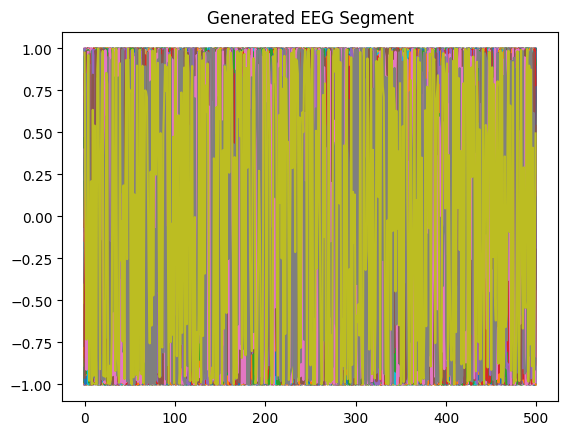

In [15]:
import matplotlib.pyplot as plt
plt.plot(x_fake[0].cpu().numpy().T)
plt.title("Generated EEG Segment")
plt.show()

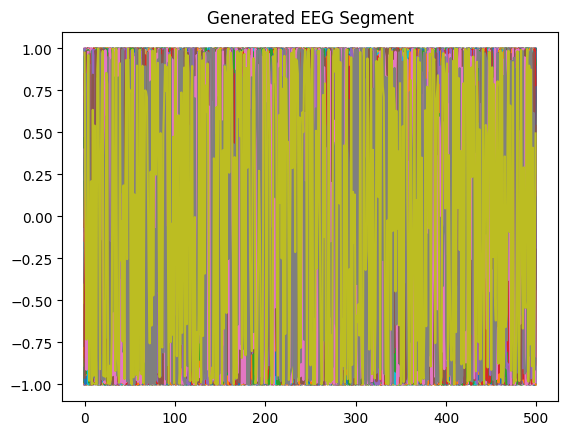

In [17]:
import matplotlib.pyplot as plt

plt.plot(x_fake[0].cpu().numpy().T)
plt.title("Generated EEG Segment")
plt.show()